<h1>Linear Regression</h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

Loading the data, label encoding and standardizing

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/spotify top tracks/tracks_with_binary_target.csv')
data.drop(['is_dance_pop'], axis=1, inplace=True)
data.set_index(['title'], inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,neo mellow,3.618665,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,detroit hip hop,42.795820,95.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,dance pop,6.235482,82.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,dance pop,16.716518,90.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,pop,29.381079,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


Since linear regression can work only with numeric data, we need to encode the variables artist and top genre. I am using LabelEncoder for variable encoding, one hot encoding would produce a large number of columns so it is not very suitable.

In [ ]:
data[['artist', 'top genre']] = data[['artist', 'top genre']].apply(LabelEncoder().fit_transform)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,53,3.618665,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,58,30,42.795820,95.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,103,28,6.235482,82.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,108,28,16.716518,90.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,26,57,29.381079,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


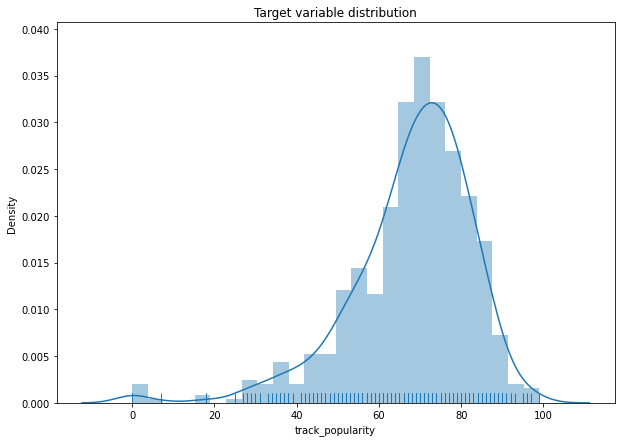

In [ ]:
plt.figure(figsize=(10,7))
sns.distplot(data['track_popularity'], kde=True, rug=True)
plt.title('Target variable distribution')
plt.show()

Inspecting between variable dependencies. Most important ones are with the target variable track_popularity

In [ ]:
X, Y = data.drop(['track_popularity'], axis=1), data['track_popularity']

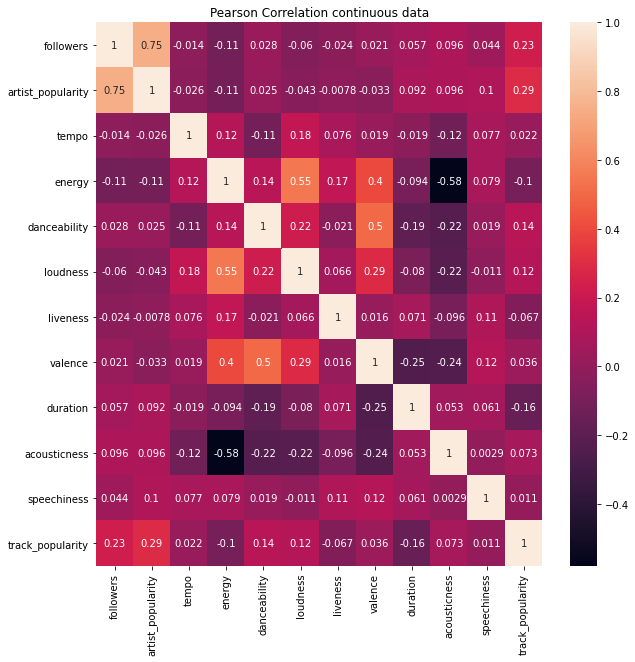

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data[data.columns.drop(['artist', 'top genre', 'year'])].corr(), annot=True)
plt.title('Pearson Correlation continuous data')
plt.show()

The target variable track_popularity has a low correlation with all of the other attributes. The highest correlations are with followers and artist_popularity, but they are still low.

Let's visualize these dependencies.

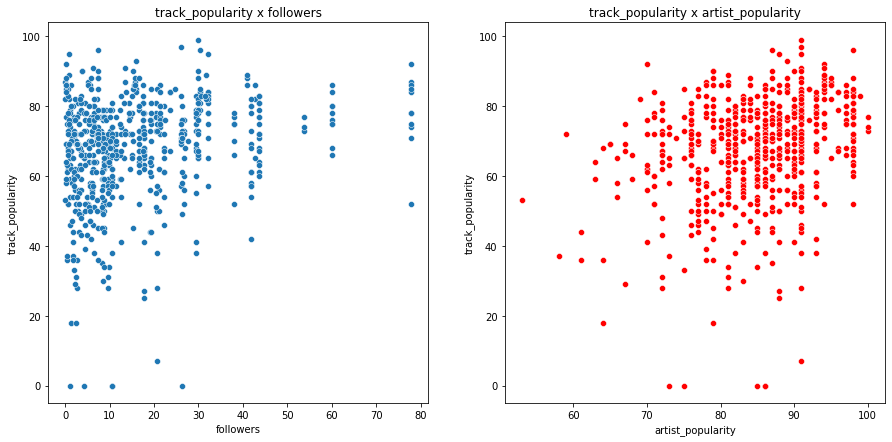

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.scatterplot(x=data['followers'], y=data['track_popularity'], ax=plt.gca())
plt.title('track_popularity x followers')
plt.subplot(1,2,2)
sns.scatterplot(x=data['artist_popularity'], y=data['track_popularity'], ax=plt.gca(), color='red')
plt.title('track_popularity x artist_popularity')
plt.show()

Plot of the estimated univariate regression line of each of the continuous features with respect to the target

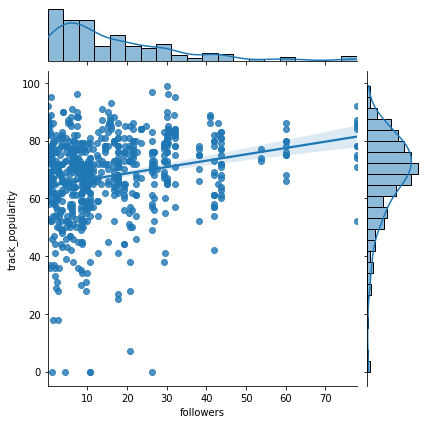

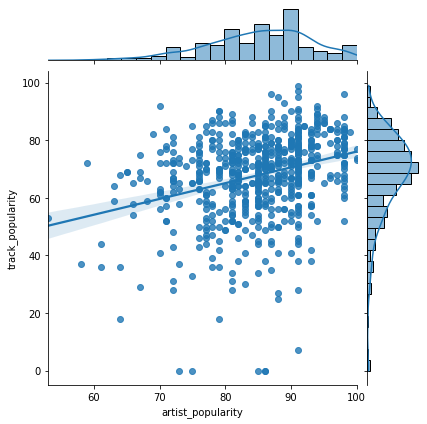

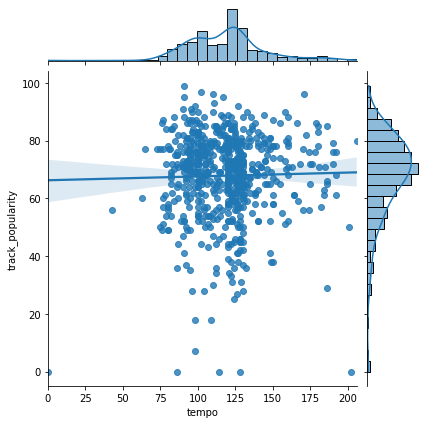

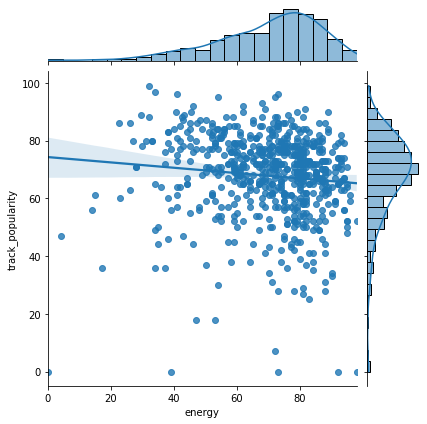

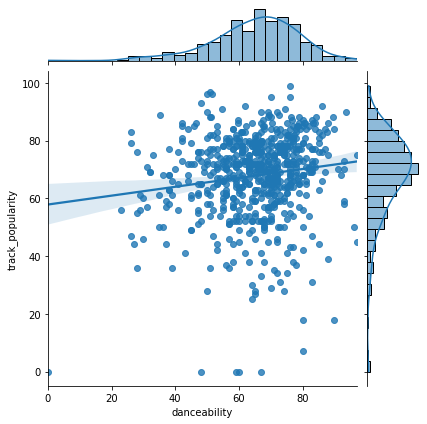

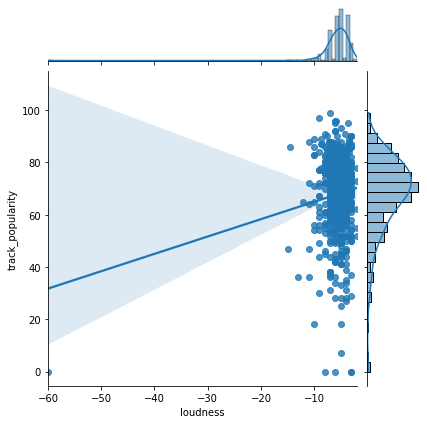

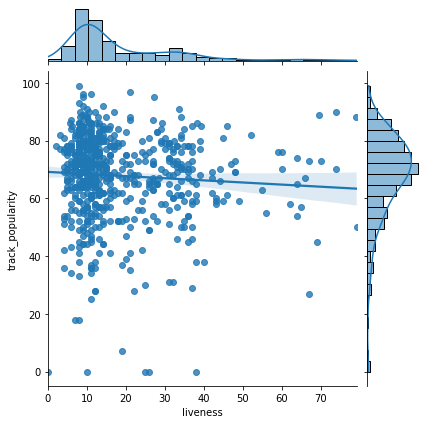

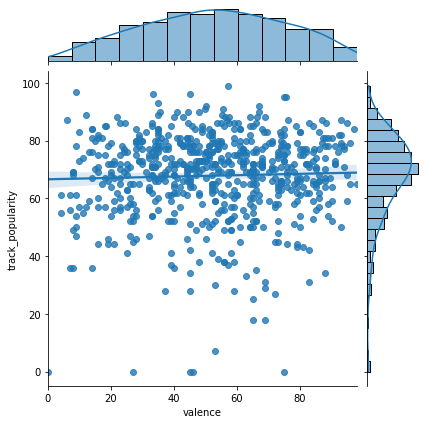

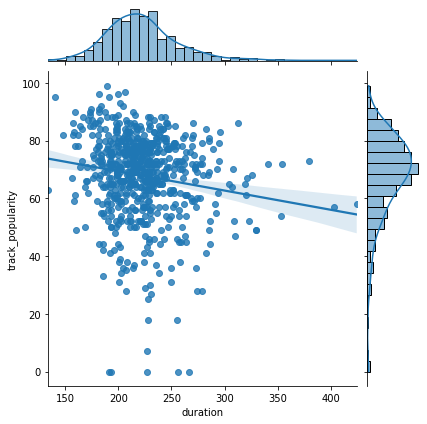

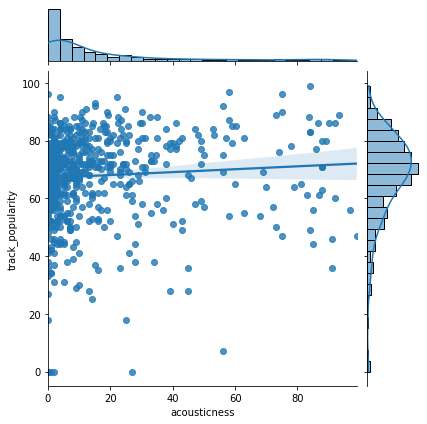

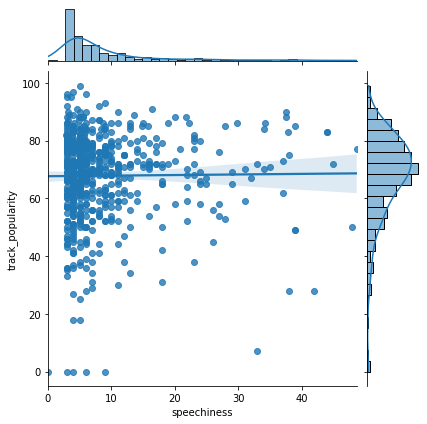

In [ ]:
for feature in X.columns.drop(['year', 'top genre', 'artist']):
  sns.jointplot(x=X[feature], y=Y, kind='reg')

We can see that most of the other variables have almost no correlation with the target, indicated by a line that is almost constant.

<h3>1. Ordinary Linear Regression</h3>

In [ ]:
def cross_validation_regression(X, Y, model): #cross validation prediction, 5 fold cv
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())

  return predicted, actual

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, 
    Y,
    test_size = 0.2,
    random_state=0
)

I am standardizing the data since linear regression expects a normal distribution. It might be more suitable for the algorithm than minmax scaling.

In [ ]:
features_x = X.columns

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

In [ ]:
linear = LinearRegression()
linear.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
coeff_lr = pd.DataFrame(linear.coef_,features_x,columns=['Coefficient'])
coeff_lr

,Coefficient
artist,1.288212
top genre,1.525611
followers,0.503807
artist_popularity,3.315499
year,3.364808
tempo,0.412450
energy,-2.456628
danceability,0.642998
loudness,4.079961
liveness,-0.611119


Plot the predicitons against the actual targets.

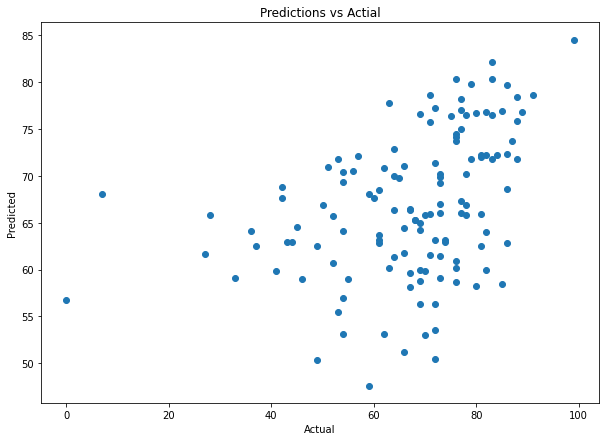

In [ ]:
y_pred = linear.predict(X_test)
plt.figure(figsize=(10,7))
plt.scatter(Y_test,y_pred)
plt.title('Predictions vs Actial')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

The errors are not very good. We saw that the correlations of the features with respect to the target variable were low, seems like the linear combination of features also has a low predictive capabilities for the model.

Plot of the error with respect tot the target variable.

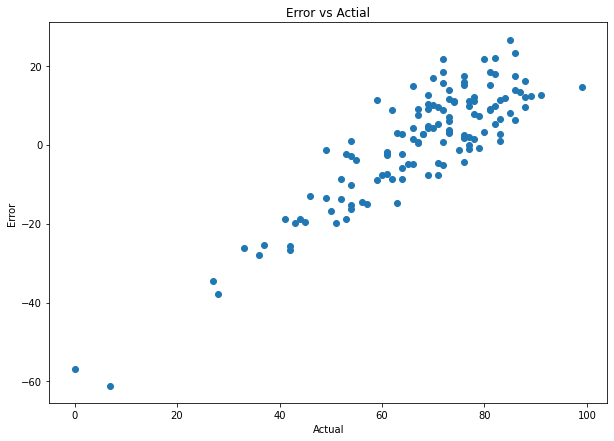

In [ ]:
y_pred = linear.predict(X_test)
plt.figure(figsize=(10,7))
plt.scatter(Y_test, np.subtract(Y_test, y_pred))
plt.title('Error vs Actial')
plt.xlabel('Actual')
plt.ylabel('Error')
plt.show()

Errors seem to be larger for larger values of the target.

In [ ]:
def print_metrics(Y_test, Y_pred):
  print(f'Mean squared error: {mean_squared_error(Y_test, Y_pred)}')
  print(f'Mean absolute error: {mean_absolute_error(Y_test, Y_pred)}')
  print(f'Root mean squared error: {np.sqrt(mean_squared_error(Y_test, Y_pred))}')
  print(f'R2 score: {r2_score(Y_test, Y_pred)}')

In [ ]:
print_metrics(Y_test, y_pred)

Mean squared error: 216.51574915827305
Mean absolute error: 11.133314110698183
Root mean squared error: 14.714474138013667
R2 score: 0.15633969699990868


The errors are pretty high and the r2 score is low. We should have in mind that the target values are not scaled and have a mean value of around 75. Maybe basis function expansion and regularization can fix this.

Plot of the error distribution.

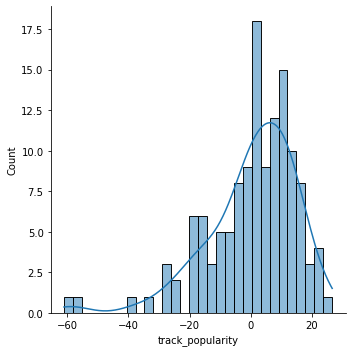

In [ ]:
sns.displot((Y_test-y_pred),bins=30, kde=True)

The error distribution is a bit left skewed, we have some outliers in the errors, but the median is around 0. For the outliers, the model predicts a high value of popularity which turns out to be lower for approximately 60.

In [ ]:
import statsmodels.api as sm

In [ ]:
feature_names = ['constant']
feature_names.extend(features_x)

Perform T-test for coefficients of the features. The null hypothesis is that the coefficient is 0, the alternative is that it is different than 0.

In [ ]:
X_train_2 = sm.add_constant(X_train)
X_test_2 = sm.add_constant(X_test)
est = sm.OLS(Y_train, X_train_2)
mod = est.fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     13.71
Date:                Tue, 11 May 2021   Prob (F-statistic):           8.19e-28
Time:                        23:09:41   Log-Likelihood:                -2052.6
No. Observations:                 522   AIC:                             4135.
Df Residuals:                     507   BIC:                             4199.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.9732      0.548    123.979      0.0

If we work with a p-value of 0.05, then the significant coefficients are X1, X2, X4, X5, X7, X9 and X12.

In [ ]:
significant_features = [] 
features_index = [0, 1, 3, 4, 6, 8, 11] #zero based index subtract 1 from features' number
for i in features_index:
  significant_features.append(features_x[i])
significant_features

['artist',
 'top genre',
 'artist_popularity',
 'year',
 'energy',
 'loudness',
 'duration']

The features that have nonzero coefficients are given above. From them, energy and duration have a negative effect on track_popularity if the other features' values are fixed. The other significant features have a positive effect on the target, for fixed values.

Visualize the values of the significant coefficients

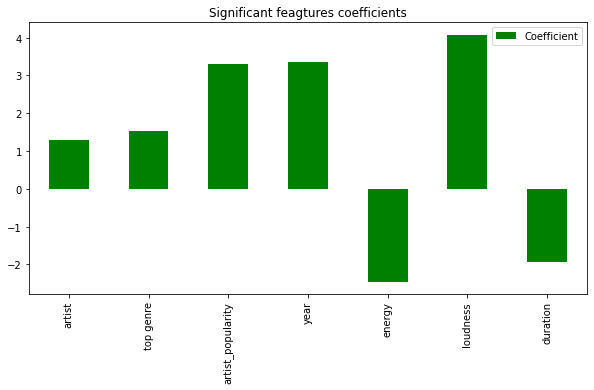

In [ ]:
plt.figure(figsize=(10,5))
coeff_lr.iloc[features_index].plot.bar(ax=plt.gca(), color='green')
plt.title('Significant feagtures coefficients')
plt.show()

Loudneess has the largest positive contribution to the target, whereas energy has the largest negative contribution for fixed values of the other features. This means that in general louder songs are more popular, and more energic songs are less popular.

In [ ]:
linear.fit(X_train[:, features_index], Y_train)
y_pred_significant = linear.predict(X_test[:, features_index])
print_metrics(Y_test, y_pred_significant)

Mean squared error: 214.1267555900637
Mean absolute error: 11.108309092731734
Root mean squared error: 14.633070613854896
R2 score: 0.16564848421495526


Using only the significant features we get a result which is a bit better, but not much. This might be due to the error that presented by a nonzero coefficient for irrelevant attributes.

<b>Cross validation 5-Fold scores</b>

In [ ]:
predicted_lin, actual_lin = cross_validation_regression(pd.DataFrame(X), Y, linear)

In [ ]:
print_metrics(actual_lin, predicted_lin)

Mean squared error: 174.1263683838175
Mean absolute error: 9.722729846600545
Root mean squared error: 13.195695070128648
R2 score: 0.20677982746642143


The scores are a bit better with cross validation. Maybe the former results are due to the randomness of the split.

<h3>2. Linear Regression with Basis Function Expansion</h3>

Adding features with a maximum degree of 2

In [ ]:
poly2 = PolynomialFeatures(degree=2)
X_poly2 = poly2.fit_transform(X)

In [ ]:
X_train_poly2, X_test_poly2, Y_train_poly2, Y_test_poly2 = train_test_split(
    X_poly2,
    Y,
    test_size = 0.2,
    random_state = 0
)

In [ ]:
linear.fit(X_train_poly2, Y_train_poly2)
coeff_lr = pd.DataFrame(linear.coef_, columns=['Coefficient'])
coeff_lr

,Coefficient
0,-2.037517e-15
1,8.031317e-01
2,6.493430e-01
3,3.943839e-01
4,2.253746e+00
...,...
115,-5.598254e-01
116,-2.571710e-01
117,-7.869564e-01
118,6.480191e-02


Too many coefficients to keep track of.

Plot the predictions against the actual values

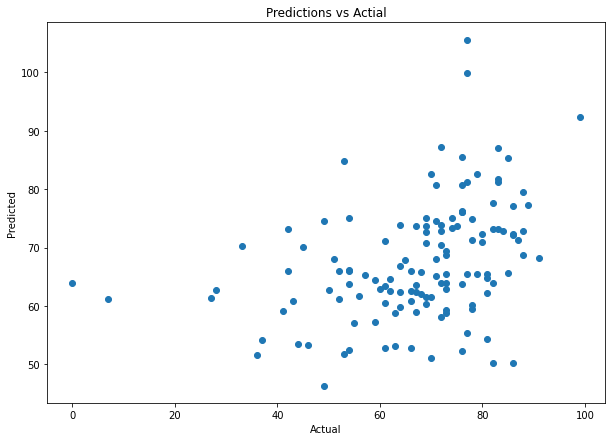

In [ ]:
y_pred = linear.predict(X_test_poly2)
plt.figure(figsize=(10,7))
plt.scatter(Y_test_poly2,y_pred)
plt.title('Predictions vs Actial')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [ ]:
print_metrics(Y_test_poly2, y_pred)

Mean squared error: 240.01448248788256
Mean absolute error: 11.298140181191002
Root mean squared error: 15.492400798064919
R2 score: 0.06477615689694527


Adding polynomial features with degree 2 makes the model's performance even worse. This may be due to overfitting and the curse of dimensionality.

Plot of the error distribution with polynomial features.

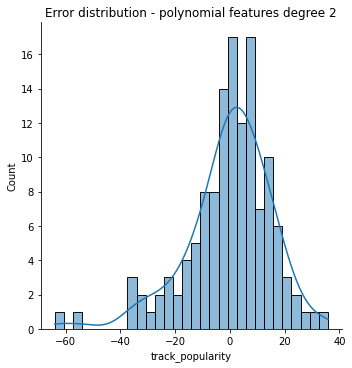

In [ ]:
sns.displot((Y_test_poly2-y_pred),bins=30, kde=True)
plt.title('Error distribution - polynomial features degree 2')
plt.show()

<b>Cross validation scores</b>

In [ ]:
predicted_lin_poly2, actual_lin_poly2 = cross_validation_regression(pd.DataFrame(X_poly2), Y, linear)

In [ ]:
print_metrics(actual_lin_poly2, predicted_lin_poly2)

Mean squared error: 1006.966057947299
Mean absolute error: 12.092890634935184
Root mean squared error: 31.73272849830753
R2 score: -3.587161597833254


We can see that the errors of the regression with polynomial features degree 2 are way worse than with the linear features.

<h3>3. Lasso Regression (L1 Regularization)
</h3>

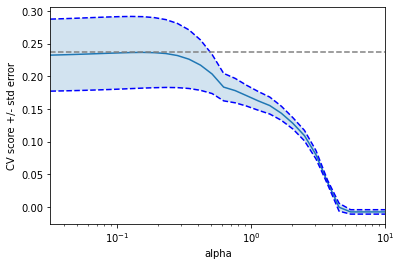

In [ ]:
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-1.5, 1, 30)

parameters = [{'alpha': alphas}]
n_folds = 5

model = GridSearchCV(lasso, parameters, cv=n_folds, refit=False)
model.fit(X_train, Y_train)
scores = model.cv_results_['mean_test_score']
scores_std = model.cv_results_['std_test_score']
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

From the plot we can see that the best value for alpha is arount 0.1

In [ ]:
lasso = Lasso(alpha=0.1, random_state=0, max_iter=10000)
lasso.fit(X_train, Y_train)
coeff_lasso = pd.DataFrame(lasso.coef_, data.columns.drop('track_popularity'), columns=['Coefficient'])
coeff_lasso

,Coefficient
artist,1.185180
top genre,1.435938
followers,0.400603
artist_popularity,3.313470
year,3.380184
tempo,0.334771
energy,-2.188697
danceability,0.557405
loudness,3.856471
liveness,-0.520245


The coefficients are a bit smaller than for the ordinary linear regression, acousticness is zero but this is expected since Lasso has an apriori belief that most of the coefficients will be zero.

Plot of the coefficient values for Lasso.

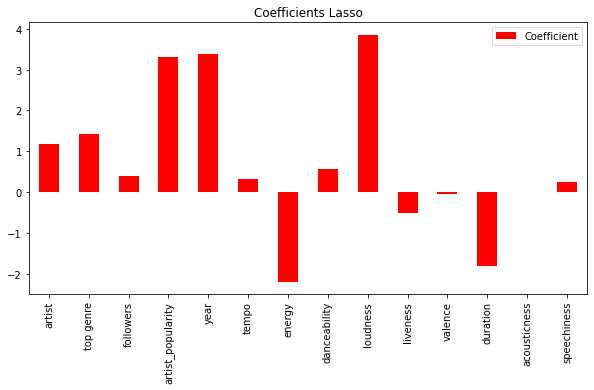

In [ ]:
plt.figure(figsize=(10,5))
coeff_lasso.plot.bar(color='red', ax=plt.gca())
plt.title('Coefficients Lasso')
plt.show()

Energy and Duration are again the features which have a negative value on the target for fixed values of the other variables.

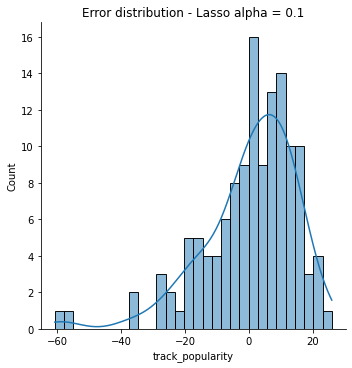

In [ ]:
sns.displot((Y_test-lasso.predict(X_test)),bins=30, kde=True)
plt.title('Error distribution - Lasso alpha = 0.1')
plt.show()

In [ ]:
print_metrics(Y_test, lasso.predict(X_test))

Mean squared error: 213.93734317190027
Mean absolute error: 11.057557015198695
Root mean squared error: 14.626597115252073
R2 score: 0.16638653555173322


Lasso show simillar performance to the ordinary linear regression. Although there is not a significant difference, it is a bit better.

<b>Cross validation scores</b>

In [ ]:
lasso_preds, lasso_actual = cross_validation_regression(pd.DataFrame(X), Y, lasso)

In [ ]:
print_metrics(lasso_actual, lasso_preds)

Mean squared error: 174.23977317120674
Mean absolute error: 9.72336154270213
Root mean squared error: 13.199991407997459
R2 score: 0.20626322009756637


Metrics on the cross validation a better performance than on the heldout data, but are almost the same as for ordinary linear regression on the cross validation

<h3>4. Lasso and Basis Function Expansion</h3>

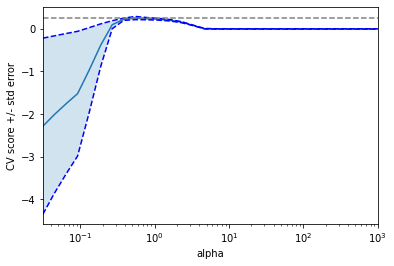

In [ ]:
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-1.5, 3, 30)

parameters = [{'alpha': alphas}]
n_folds = 5

model = GridSearchCV(lasso, parameters, cv=n_folds, refit=False)
model.fit(X_train_poly2, Y_train_poly2)
scores = model.cv_results_['mean_test_score']
scores_std = model.cv_results_['std_test_score']
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

From the plot we can see that the best score is achieved around alpha of value 1.

In [ ]:
lasso = Lasso(alpha=0.9, random_state=0, max_iter=10000)
lasso.fit(X_train_poly2, Y_train_poly2)

Lasso(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)

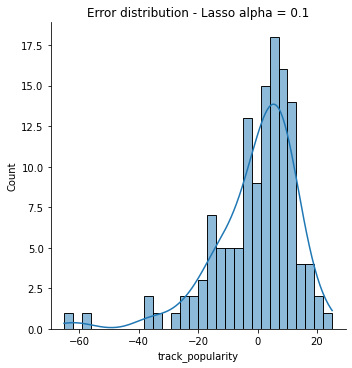

In [ ]:
sns.displot((Y_test_poly2-lasso.predict(X_test_poly2)),bins=30, kde=True)
plt.title('Error distribution - Lasso alpha = 0.1')
plt.show()

In [ ]:
print_metrics(Y_test_poly2, lasso.predict(X_test_poly2))

Mean squared error: 197.65100060843508
Mean absolute error: 10.191025064798222
Root mean squared error: 14.058840656627241
R2 score: 0.22984677230251238


The R2 score is higher but that may be due to the large number of features added to the model wiht polynomial features. Thus, we cannot conclude that this model performs better.

In [ ]:
lasso_poly_preds, lasso_poly_actual = cross_validation_regression(pd.DataFrame(X_poly2), Y, lasso)

In [ ]:
print_metrics(lasso_poly_preds, lasso_poly_actual)

Mean squared error: 172.16271920010286
Mean absolute error: 9.610156353221122
Root mean squared error: 13.121079193423949
R2 score: -3.6982207907103986


Again this scores have not improved with adding polynomial features with respect to Lasso with only linear features.

<h3>5. Ridge Regression (L2 Regularization)</h3>

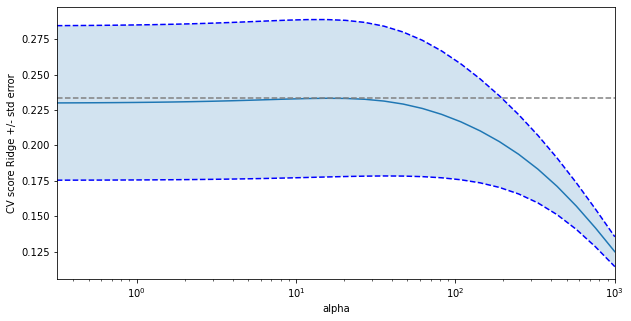

In [ ]:
ridge = Ridge(random_state=0, max_iter=10000)
alphas = np.logspace(-0.5, 3, 30)

parameters = [{'alpha': alphas}]
n_folds = 5
plt.figure(figsize=(10,5))
model = GridSearchCV(ridge, parameters, cv=n_folds, refit=False)
model.fit(X_train, Y_train)
scores = model.cv_results_['mean_test_score']
scores_std = model.cv_results_['std_test_score']
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score Ridge +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

From the plot we can see that the best value for aplha is around 10 to 20.

In [ ]:
ind = -1
for i, sc in enumerate(scores):
  if sc == np.max(scores):
    ind = i
alpha = alphas[ind]
alpha

15.475873545578892

In [ ]:
ridge = Ridge(alpha=15.5, random_state=0, max_iter=10000)
ridge.fit(X_train, Y_train)
coeff_ridge = pd.DataFrame(ridge.coef_, data.columns.drop('track_popularity'), columns=['Coefficient'])
coeff_ridge

,Coefficient
artist,1.268999
top genre,1.499947
followers,0.629301
artist_popularity,3.132047
year,3.293501
tempo,0.429319
energy,-2.206216
danceability,0.711587
loudness,3.838948
liveness,-0.611017


The coefficients for Ridge are smaller than the ordinary Linear regression, but there are no zero coefficients.

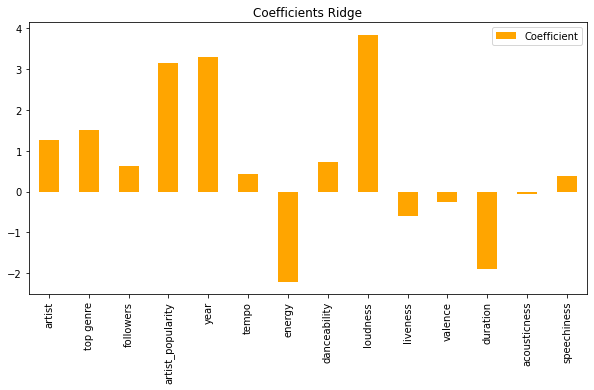

In [ ]:
plt.figure(figsize=(10,5))
coeff_ridge.plot.bar(color='orange', ax=plt.gca())
plt.title('Coefficients Ridge')
plt.show()

The same can be said about the coefficients with Ridge as for Lasso and ordinary linear regression. Except in this case the magnitude of the coefficients is larger.

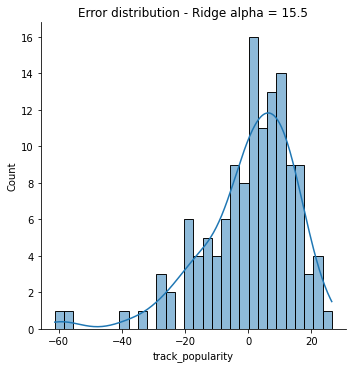

In [ ]:
sns.displot((Y_test-ridge.predict(X_test)),bins=30, kde=True)
plt.title('Error distribution - Ridge alpha = 15.5')
plt.show()

In [ ]:
print_metrics(Y_test, ridge.predict(X_test))

Mean squared error: 216.21803793592457
Mean absolute error: 11.116527142398052
Root mean squared error: 14.704354386912897
R2 score: 0.15749973797166006


The error is quite similar to lasso, but is a bit worse.
<br><b>Cross validation scores</b>

In [ ]:
ridge_preds, ridge_actual = cross_validation_regression(pd.DataFrame(X), Y, ridge)

In [ ]:
print_metrics(ridge_preds, ridge_actual)

Mean squared error: 174.4364667252563
Mean absolute error: 9.728544234288355
Root mean squared error: 13.207439824782709
R2 score: -2.434390342797441


Again, the cross validation errors for Ridge are almost the same as for Lasso.

<h3>6. Ridge and Basis Function Expansion</h3>

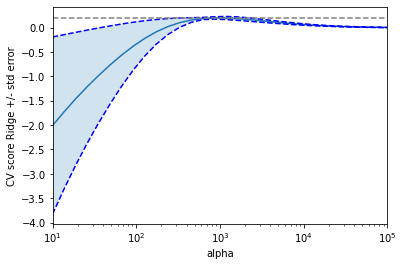

In [ ]:
ridge = Ridge(random_state=0, max_iter=10000)
alphas = np.logspace(1, 5, 30)

parameters = [{'alpha': alphas}]
n_folds = 5

model = GridSearchCV(ridge, parameters, cv=n_folds, refit=False)
model.fit(X_train_poly2, Y_train_poly2)
scores = model.cv_results_['mean_test_score']
scores_std = model.cv_results_['std_test_score']
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score Ridge +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

From the plot we can see that the best value for alpha is close to 1000.

In [ ]:
ind = -1
for i, sc in enumerate(scores):
  if sc == np.max(scores):
    ind = i
alpha = alphas[ind]
alpha

853.1678524172805

In [ ]:
ridge = Ridge(alpha=alpha, random_state=0, max_iter=10000)
ridge.fit(X_train_poly2, Y_train_poly2)

Ridge(alpha=853.1678524172805, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=0, solver='auto', tol=0.001)

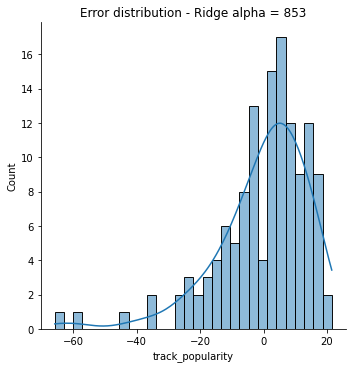

In [ ]:
sns.displot((Y_test_poly2-ridge.predict(X_test_poly2)),bins=30, kde=True)
plt.title('Error distribution - Ridge alpha = 853')
plt.show()

In [ ]:
print_metrics(Y_test_poly2, ridge.predict(X_test_poly2))

Mean squared error: 215.2507962470087
Mean absolute error: 10.83730719151989
Root mean squared error: 14.671427887121578
R2 score: 0.16126862508272455


<b>Cross validation errors</b>

In [ ]:
ridge_preds, ridge_actual = cross_validation_regression(pd.DataFrame(X_poly2), Y, ridge)

In [ ]:
print_metrics(ridge_preds, ridge_actual)

Mean squared error: 180.70818478959328
Mean absolute error: 9.764204149175246
Root mean squared error: 13.442774445388618
R2 score: -2.1906273157609983


There is no significant improvement in the errors from using polynomial features.

Since the model seems to overfit for polynomial features even of degree 2, there is no need to try for higher values. This can be seen from the large values of the regularization parameters even though the values of the variables are standardized. 